# Исследование эффективности нововведения путём проведения А/B теста

**Цель:** Изучить, как ведут себя пользователи мобильного приложения. 
Изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
После этого исследовать результаты A/A/B-эксперимента.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Обзор-и-предобработка-данных" data-toc-modified-id="Обзор-и-предобработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обзор и предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Изучение-воронки-событий" data-toc-modified-id="Изучение-воронки-событий-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Изучение воронки событий</a></span></li><li><span><a href="#Проверка-результатов-А/B-теста" data-toc-modified-id="Проверка-результатов-А/B-теста-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Проверка результатов А/B теста</a></span></li><li><span><a href="#Исследование-данных-А/В-теста-в-динамике" data-toc-modified-id="Исследование-данных-А/В-теста-в-динамике-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Исследование данных А/В теста в динамике</a></span></li><li><span><a href="#Выводы-и-рекомендации:" data-toc-modified-id="Выводы-и-рекомендации:-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Выводы и рекомендации:</a></span></li></ul></div>

## Описание проекта

Будучи аналитиком в стартапе, который продаёт продукты питания нужно разобраться, как ведут себя пользователи мобильного приложения. 

Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо выяснить, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, мы сможем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

## Описание данных

Каждая запись в логе — это действие пользователя, или событие. \
`EventName` — название события;\
`DeviceIDHash` — уникальный идентификатор пользователя;\
`EventTimestamp` — время события;\
`ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Обзор и предобработка данных

In [46]:
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import matplotlib.ticker as ticker
import math

In [47]:
try:
    data = pd.read_csv('D:\Jypiter\datasets\8_event_analytics_and_A-B_test_research\logs_exp.csv', sep='\t')
                       
except:
    data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [48]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [50]:
#Переименуме названия столбцов в более привычные в змеином регистре
data.columns = ['event_name', 'user_id', 'event_datetime', 'group']

In [51]:
data.head()

,event_name,user_id,event_datetime,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [52]:
data['event_datetime'] = pd.to_datetime(data['event_datetime'], unit="s")
data['event_date'] = data['event_datetime'].dt.date

In [53]:
data.head()

,event_name,user_id,event_datetime,group,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [54]:
data.isna().sum()

event_name        0
user_id           0
event_datetime    0
group             0
event_date        0
dtype: int64

In [55]:
data.duplicated().sum()

413

In [56]:
data = data.drop_duplicates(ignore_index=True)

In [57]:
#Проверим, какие значения лежат в столбцах: 'event_name' и 'group'. Убедимся, что нет неявных дубликатов.
for i in [0, 3]:
    print(data.columns[i], ': ', data[data.columns[i]].unique(), sep='')

event_name: ['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']
group: [246 248 247]


Неявные дубликаты отсутствуют.

<div style="border:solid Green 2px; padding: 20px"> 
<b>Вывод по разделу:</b><br>
    1. Пропуски отсутствуют.<br>
    2. Явные строки-дубликаты удалены (473 из 244126 строк).<br>
    3. Данные в столбце 'event_date' переведены из 'int' в 'datetime'.<br>
    4. Добавлен отдельный столбец с датами.

## Исследовательский анализ данных

In [58]:
print('Количество событий:', len(data['event_name']))
print('Количество уникальный событий:', data['event_name'].nunique())

Количество событий: 243713
Количество уникальный событий: 5


In [59]:
print('Количество уникальный пользователей:', data['user_id'].nunique())

Количество уникальный пользователей: 7551


In [60]:
print('Количество событий на пользователя:', round(len(data['event_name']) / data['user_id'].nunique(), 2))
print('Количество уникальный событий на пользователя:', round(data.groupby('user_id')['event_name'].nunique().mean(), 2))

Количество событий на пользователя: 32.28
Количество уникальный событий на пользователя: 2.67


<div style="border:solid Green 2px; padding: 20px"> 
    Исходя из этой информации, можно заключить, что в среднем пользователи проходят менее 3 уникальных событий, скорее всего многие не доходят до успешной оплаты. Выясним это в следующем разделе.

In [61]:
print('Минимальная дата:', min(data['event_date']))
print('Максимальная дата:', max(data['event_date']))
print('Период, за который предоставлены данные:', max(data['event_date']) - min(data['event_date']))

Минимальная дата: 2019-07-25
Максимальная дата: 2019-08-07
Период, за который предоставлены данные: 13 days, 0:00:00


<div style="border:solid Green 2px; padding: 20px"> 
    В нашем распоряжении данные с 25 июля 2019 по 7 августа 2019 года, т.е. за 13 дней.
    
    
Взглянем на всём ли этом временном промежутке имеется сопоставимое количество данных:
    

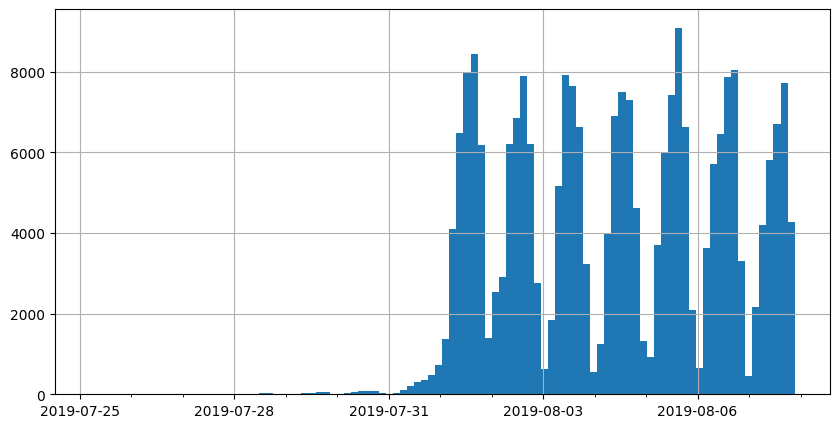

In [62]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

data['event_datetime'].hist(bins=100)

#  Устанавливаем интервал основных делений:
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
#  Устанавливаем интервал вспомогательных делений:
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

plt.show()

<div style="border:solid Green 2px; padding: 20px"> 
    Видно, что полные данные появлятся с 1 августа, а до этой даты их слишком мало, чтобы использовать их для анализа.
    Также можно заметить, что количество действий пользователей циклично: во второй половине дня максимально, ночью минимально, что соответствует логике и говорит о том, что данные выгружены в соответствии с правильным часовым поясом.

<div style="border:solid Green 2px; padding: 20px"> 
    Создадим отфильтрованный датафрейм, где оставим данные с 1 августа:

In [63]:
data_actual = data[data['event_date'] >= pd.to_datetime('2019-08-01')]

<div style="border:solid Green 2px; padding: 20px"> 
    Проверим, сколько пользователей совершали действия до 1 августа, но не совершали после этой даты. Аналогично с уникальными событиями и событиями. Это будут данные, которых мы "потеряем" в анализе. Нужно убедиться что их относительное количество не значимое.

In [64]:
print('Было пользователей:', data['user_id'].nunique())
print('Стало пользователей:', data_actual['user_id'].nunique())
print('Потеряно пользователей:', data['user_id'].nunique() - data_actual['user_id'].nunique())

Было пользователей: 7551
Стало пользователей: 7534
Потеряно пользователей: 17


In [65]:
print('Было уникальный событий:', data['event_name'].nunique())
print('Стало уникальный событий:', data_actual['event_name'].nunique())
print('Потеряно пользователей:', data['event_name'].nunique() - data_actual['event_name'].nunique())

Было уникальный событий: 5
Стало уникальный событий: 5
Потеряно пользователей: 0


In [66]:
print('Было событий:', data['event_name'].count())
print('Стало событий:', data_actual['event_name'].count())
print('Потеряно событий:', data['event_name'].count() - data_actual['event_name'].count())
print('В процентах:', round((data['event_name'].count() - data_actual['event_name'].count()) / data['event_name'].count() * 100, 2))

Было событий: 243713
Стало событий: 240887
Потеряно событий: 2826
В процентах: 1.16


In [67]:
for i in data_actual['group'].unique():
    print('В группе ', i, ': ',  len(data_actual[data_actual['group'] == i]), ' пользователей', sep='')

В группе 246: 79302 пользователей
В группе 247: 77022 пользователей
В группе 248: 84563 пользователей


<div style="border:solid Green 2px; padding: 20px"> 
- Всего 17 пользователей из 7551 были "потеряны".<br>
- Всего 1.16% событий было потеряно.<br>
- Ни одного уникального события не было потеряно.<br>
- Ни одной группы не было потеряно. Причем во всех трёх группах осталось достаточное количество пользователей.<br>
По всем параметрам потеряно незначительное количество данных. Движемся дальше

## Изучение воронки событий

<div style="border:solid Green 2px; padding: 20px"> 
  Проранжируем уникальные события по частоте появления: 

In [68]:
events_quantity = data_actual.groupby('event_name').agg({'user_id':'count'})
events_quantity.rename(columns={'user_id':'events_quantity'}, inplace=True)
events_quantity.sort_values(by='events_quantity', ascending=False)

,events_quantity
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


<div style="border:solid Green 2px; padding: 20px"> 
Рассчитаем сколько пользователей совершали каждое из событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие: 

In [69]:
events_groups = data_actual.groupby('event_name').agg({'user_id':'nunique'})
events_groups.rename(columns={'user_id':'nunique_user_id'}, inplace=True)
events_groups['percent_of_all, %'] = round(events_groups['nunique_user_id'] / data_actual['user_id'].nunique() * 100, 2)
events_groups = events_groups.sort_values(by='percent_of_all, %', ascending=False)
events_groups

,nunique_user_id,"percent_of_all, %"
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


<div style="border:solid Green 2px; padding: 20px"> 
❗ Интересный факт, что не 100% уникальных пользователей проходили черех "Появление главного экрана". Возможно существует возможность попасть сразу на следующие страницы, минуя предыдущие. Либо они проходили его вне дат исследования.

События в мобильном приложении должны происходить в следующем порядке:
1. `MainScreenAppear` - Появление главного экрана
2. `Tutorial` - Обучающий урок
3. `OffersScreenAppear` - Появление экрана предложений
4. `CartScreenAppear`	- Появление экрана корзины
5. `PaymentScreenSuccessful` - Появление экрана об успешном проведении оплаты

<div style="border:solid Green 2px; padding: 20px"> 
Можно заметить, что туториал проходят всего 11,15% пользователей. Скорее всего он не обязательный, и многие пользователи от него отказывается, поэтому исключим его из основной цепочки событий.<br>
Добавим столбец "CTR", в котором посчитаем какой % пользователей переходит с предыдущего шага:

In [70]:
events_groups.drop(labels = ['Tutorial'], axis = 0, inplace=True)
events_groups['CTR, %'] = 100.0

for i in range(len(events_groups)):    
    if i == 0:
        events_groups['CTR, %'][i] = np.nan
    else:
        events_groups['CTR, %'][i] = round(events_groups['nunique_user_id'][i] / events_groups['nunique_user_id'][i-1] * 100, 2)
    
events_groups

C:\Users\andru\AppData\Local\Temp\ipykernel_15788\2874879173.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_groups['CTR, %'][i] = np.nan
C:\Users\andru\AppData\Local\Temp\ipykernel_15788\2874879173.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_groups['CTR, %'][i] = round(events_groups['nunique_user_id'][i] / events_groups['nunique_user_id'][i-1] * 100, 2)


,nunique_user_id,"percent_of_all, %","CTR, %"
event_name,,,
MainScreenAppear,7419,98.47,NaN
OffersScreenAppear,4593,60.96,61.91
CartScreenAppear,3734,49.56,81.30
PaymentScreenSuccessful,3539,46.97,94.78


<div style="border:solid Green 2px; padding: 20px"> 
Визулизируем воронку пути пользователя по событиям:

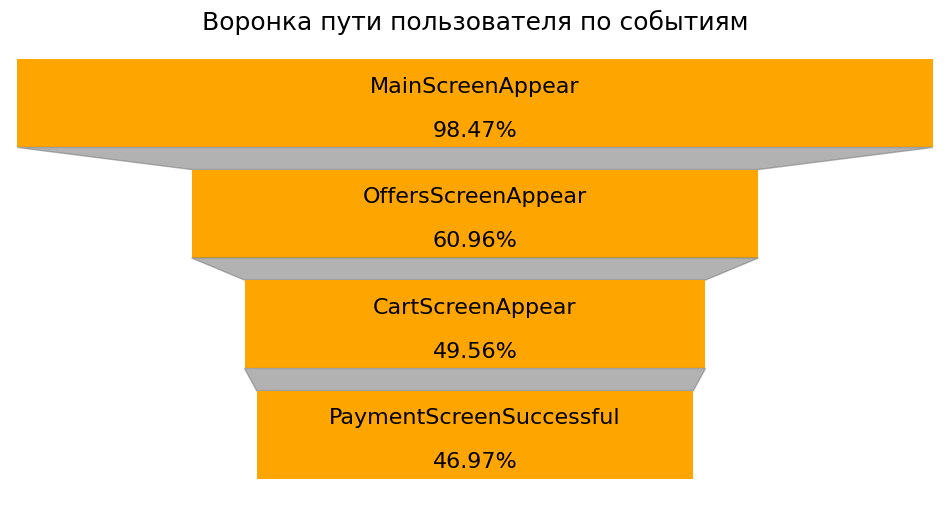

In [71]:

y = [4,3,2,1]
x = events_groups['percent_of_all, %']
labels = events_groups.index
x_max = 100
x_min = 0
x_range = x_max - x_min

fig, ax = plt.subplots(1, figsize=(12,6))
for idx, val in enumerate(x):
    left = (x_range - val)/2
    plt.barh(y[idx], x[idx], left = left, 
             color='orange', height=.8)
    # label
    plt.text(50, y[idx]+0.1, labels[idx], ha='center',
              fontsize=16)
    # value
    plt.text(50, y[idx]-0.3, '{:.2%}'.format(x[idx]/100), ha='center',
              fontsize=16)
    
    if idx != len(x)-1:
        next_left = (x_range - x[idx+1])/2
        shadow_x = [left, next_left, 
                    100-next_left, 100-left, left]
        
        shadow_y = [y[idx]-0.4, y[idx+1]+0.4, 
                    y[idx+1]+0.4, y[idx]-0.4, y[idx]-0.4]
        plt.fill(shadow_x, shadow_y, color='grey', alpha=0.6)
plt.xlim(x_min, x_max)
plt.axis('off')
plt.title('Воронка пути пользователя по событиям', loc='center', fontsize=18)
plt.show()

<div style="border:solid Green 2px; padding: 20px"> 
Больше всего пользователей теряется при переходе из главного экрана на экран предложений.
Это говорит о том, что почти 40% увидев главный экран, не доходит до экрана предложений. Возможно, что-то на главном экране отталкивает пользователей, либо это случайные пользователи, ожидавшие увидеть что-то другое в нашем приложении.

In [72]:
print('От первого события до оплаты теряется', '{0:.2%}'
      .format(
          round(
              (1 - events_groups['nunique_user_id']['PaymentScreenSuccessful'] / events_groups['nunique_user_id']['MainScreenAppear']), 4
               )
             ), 'пользователей'
     )

От первого события до оплаты теряется 52.30% пользователей


<div style="border:solid Green 2px; padding: 20px"> 
Вывод по разделу: На текущий момент каждый второй пользователь, зашедший в приложение не доходит до экрана с успешной оплатой. С одной стороны процент платящих пользователей - высокий, с другой стороны его можно увеличить, поняв причины, почему клиент не проходит весь путь до покупки. В особенности, почему он уходит в большинстве случаев после стартового экрана.

## Проверка результатов А/B теста

<div style="border:solid Green 2px; padding: 20px"> 
Проверим:<br>
    1. Cколько пользователей попало в каждую группу теста.<br>
    2. Проверим наличие пересекающихся пользователей.<br>

In [73]:
for i in data_actual['group'].unique():
    if i == 246 or i == 247:
        print('В контрольной группе ', i, ': ',  len(data_actual[data_actual['group'] == i]), ' пользователей', sep='')
    else:
        print('В экспериментальной группе ', i, ': ',  len(data_actual[data_actual['group'] == i]), ' пользователей', sep='')

В контрольной группе 246: 79302 пользователей
В контрольной группе 247: 77022 пользователей
В экспериментальной группе 248: 84563 пользователей


In [74]:
#Сгруппируем по visitorId. Агрегируем кол-во уникальных значений.
users_grouped = data_actual.groupby('user_id').nunique()

#Пользователей с двумя уникальными группами считаем задвоившимися
doubled_users = users_grouped[users_grouped['group'] >= 2].index
print('Количество пользователей, находящихся в нескольких группах:', len(doubled_users))

Количество пользователей, находящихся в нескольких группах: 0


<div style="border:solid Green 2px; padding: 20px"> 

План действий далее такой:

1. Проверим, находят ли статистические критерии разницу между контрольными выборками 246 и 247.
2. Проверим, находят ли статистические критерии разницу между контрольной и тестовой выборками 246 и 248.
3. Проверим, находят ли статистические критерии разницу между контрольной и тестовой выборками 247 и 248.
4. Проверим, находят ли статистические критерии разницу между объединённой контрольной и экспериментальной выборками (246 + 247) и 248.

Для проверки статистической значимости различия долей будем использовать Z-тест.<br>
Уровень значимости рассчитаем по методу Шидака: 1 - (1 - 0.05)^(1/20) = 0.00256,
    где 20 - общее количество проверяемых гипотез (4 сравнения по 5 событий)

<div style="border:solid Green 2px; padding: 20px"> 
<b>H0</b> - нулевая гипотеза - доли пользователей, совершивших событие, <b>равны</b> в двух контрольных группах: 246 и 247<br>
<b>H1</b> - альтернативная гипотеза - доли пользователей, совершивших событие, <b>различны</b> в двух контрольных группах: 246 и 247

In [75]:
#Функция для проверки статистической значимости между двумя выборками

def z_test(group_A, group_B, event, alpha):
    users_A = group_A['user_id'].nunique() #Всего пользователей в группе А
    users_B = group_B['user_id'].nunique() #Всего пользователей в группе B
    
    event_A = group_A[group_A['event_name']==event]['user_id'].nunique() #Всего пользователей в группе А, совершивших событие
    event_B = group_B[group_B['event_name']==event]['user_id'].nunique() #Всего пользователей в группе В, совершивших событие
    
    p1 = event_A / users_A #доля пользоватлей группы А, совершивших событие 
    p2 = event_B / users_B #доля пользоватлей группы В, совершивших событие
    
    print('Пропорция группы А:', p1)
    print('Пропорция группы B:', p2)
    
    difference = p1 - p2
    print('Разница пропорций:', difference)
    
    p_combined = (event_A + event_B) / (users_A + users_B) #общая доля пользоватлей двух групп, совершивших событие
    print('Пропорция в объединенной выборке:', p_combined)
    
    z_value = difference / math.sqrt((p_combined * (1 - p_combined) * (1 / users_A + 1 / users_B)))
    print('z:', z_value)
    
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p_value:', p_value)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

Подготовим срезы для групп:

In [76]:
group_246 = data_actual[(data_actual['group'] == 246)]
group_247 = data_actual[(data_actual['group'] == 247)]
group_248 = data_actual[(data_actual['group'] == 248)]
group_246_247  = data_actual[(data_actual['group']==246) | (data_actual['group']==247)]

In [77]:
#Проверка статистической значимоти между группами 246 и 247 в долях пользователей, совершивших событие
alpha = 0.00256 # Уровень статистической значимости, рассчитанный по методу Шидака

for i in data_actual['event_name'].unique(): # Цикл для каждого события
    print(i)
    z_test(group_246, group_247, i, alpha)
    print()

Tutorial
Пропорция группы А: 0.11191626409017713
Пропорция группы B: 0.11261440509351373
Разница пропорций: -0.0006981410033365942
Пропорция в объединенной выборке: 0.11226736041624975
z: -0.0781614596617372
p_value: 0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear
Пропорция группы А: 0.9863123993558777
Пропорция группы B: 0.9852765618782332
Разница пропорций: 0.0010358374776444634
Пропорция в объединенной выборке: 0.9857914748849309
z: 0.3093441851418436
p_value: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
Пропорция группы А: 0.6207729468599034
Пропорция группы B: 0.6048547552725826
Разница пропорций: 0.015918191587320774
Пропорция в объединенной выборке: 0.6127676605963578
z: 1.154987713610383
p_value: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
Пропорция группы А: 0.5096618357

<div style="border:solid Green 2px; padding: 20px"> 
Ни по одному событию нет статистически значимой разницы. Можно сделать вывод о равенстве долей пользователей, совершивших события в двух контрольных выборках: 246 и 247.<br>
Можно заключить, что разбиение на группы работает корректно.

<div style="border:solid Green 2px; padding: 20px"> 
<b>H0</b> - нулевая гипотеза - доли пользователей, совершивших событие, <b>равны</b> в контрольной и экспериментальной группах: 246 и 248<br>
<b>H1</b> - альтернативная гипотеза - доли пользователей, совершивших событие, <b>различны</b> в контрольных и экспериментальной группах: 246 и 248

In [78]:
#Проверка статистической значимоти между группами 246 и 247 в долях пользователей, совершивших событие

alpha = 0.00256 # Уровень статистической значимости, рассчитанный по методу Шидака

for i in data_actual['event_name'].unique(): # Цикл для каждого события
    print(i)
    z_test(group_246, group_248, i, alpha)
    print()

Tutorial
Пропорция группы А: 0.11191626409017713
Пропорция группы B: 0.10997240835632636
Разница пропорций: 0.0019438557338507662
Пропорция в объединенной выборке: 0.11093407687711611
z: 0.21928326020412683
p_value: 0.8264294010087645
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear
Пропорция группы А: 0.9863123993558777
Пропорция группы B: 0.9826566811194324
Разница пропорций: 0.0036557182364452823
Пропорция в объединенной выборке: 0.9844652459669389
z: 1.0472762353383693
p_value: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
Пропорция группы А: 0.6207729468599034
Пропорция группы B: 0.6034686637761135
Разница пропорций: 0.01730428308378984
Пропорция в объединенной выборке: 0.6120294761999602
z: 1.2580821335711887
p_value: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
Пропорция группы А: 0.5096618357

<div style="border:solid Green 2px; padding: 20px"> 
На основании анализа выше, можно сделать вывод о равенстве долей пользователей, совершивших события в контрольной и экспериментальной группах: 246 и 248.<br>

<div style="border:solid Green 2px; padding: 20px"> 
<b>H0</b> - нулевая гипотеза - доли пользователей, совершивших событие, <b>равны</b> в двух контрольных группах: 247 и 248<br>
<b>H1</b> - альтернативная гипотеза - доли пользователей, совершивших событие, <b>различны</b> в контрольной и экспериментальной группах: 247 и 248

In [79]:
alpha = 0.00256

for i in data_actual['event_name'].unique():
    print(i)
    z_test(group_247, group_248, i, alpha)
    print()

Tutorial
Пропорция группы А: 0.11261440509351373
Пропорция группы B: 0.10997240835632636
Разница пропорций: 0.0026419967371873604
Пропорция в объединенной выборке: 0.11128712871287129
z: 0.2984969253006019
p_value: 0.765323922474501
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear
Пропорция группы А: 0.9852765618782332
Пропорция группы B: 0.9826566811194324
Разница пропорций: 0.002619880758800819
Пропорция в объединенной выборке: 0.983960396039604
z: 0.740980338642352
p_value: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
Пропорция группы А: 0.6048547552725826
Пропорция группы B: 0.6034686637761135
Разница пропорций: 0.0013860914964690663
Пропорция в объединенной выборке: 0.6041584158415841
z: 0.1007086015299871
p_value: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
Пропорция группы А: 0.49263828093911

<div style="border:solid Green 2px; padding: 20px"> 
На основании анализа выше, можно сделать вывод о равенстве долей пользователей, совершивших события в контрольной и экспериментальной группах: 247 и 248.<br>

Таким образом тестовая группа, видевшая новую страницу с измененным шрифтом не показала статистически лучшие результаты по дохождению до экрана успешной оплаты. 

<div style="border:solid Green 2px; padding: 20px"> 
<b>H0</b> - нулевая гипотеза - доли пользователей в группе, в объединённой контрольной и экспериментальной: (246 + 247) и 248, совершивших событие, <b>равны</b> <br>
<b>H1</b> - альтернативная гипотеза - доли пользователейв группе, объединённой из двух контрольных групп и экспериментальной: (246 + 247) и 248 совершивших событие, <b>различны</b> 

In [80]:
alpha = 0.00256

for i in data_actual['event_name'].unique():
    print(i)
    z_test(group_246_247, group_248, i, alpha)
    print()

Tutorial
Пропорция группы А: 0.11226736041624975
Пропорция группы B: 0.10997240835632636
Разница пропорций: 0.0022949520599233886
Пропорция в объединенной выборке: 0.11149455800371648
z: 0.2991016694401563
p_value: 0.764862472531507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear
Пропорция группы А: 0.9857914748849309
Пропорция группы B: 0.9826566811194324
Разница пропорций: 0.0031347937654985225
Пропорция в объединенной выборке: 0.9847358640828245
z: 1.048854111361149
p_value: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
Пропорция группы А: 0.6127676605963578
Пропорция группы B: 0.6034686637761135
Разница пропорций: 0.009298996820244265
Пропорция в объединенной выборке: 0.6096363153703213
z: 0.7819303684733905
p_value: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
Пропорция группы А: 0.50110066039

<div style="border:solid Green 2px; padding: 20px"> 
На основании анализа выше, можно сделать вывод о равенстве долей пользователей, совершивших события в группе, объединённой контрольной и экспериментальной группах: 247 и 248.<br>

## Исследование данных А/В теста в динамике

<div style="border:solid Green 2px; padding: 20px"> 
    Для полноты анализа взглянем на данные в динамике. Как менялась доля пользователей, совершивших события в разных группах.<br>
Для этого напишем функцию по созданию куммулятивных значений о долях пользователей, совершивших события по группам в динамике.<br>
Каждое событие выведем на отдельном графике.

In [81]:
datesGroups = data_actual[['event_date', 'group']].drop_duplicates() #Набор уникальных пар дата + группа

#Создаем таблицу с накопленным количеством пользователей по датам с разбивкой на группы
cumulative_share = datesGroups.apply(
    lambda x: data_actual[
        np.logical_and(
            data_actual['event_date'] <= x['event_date'], #Накапливаем значения по дате
            data_actual['group'] == x['group'] #фильтр по группе
        )
    ].agg(
        {
            'event_date': 'max',
            'group': 'max',
            'user_id': 'nunique', # кол-во пользователей, совершивших любое событие до этой даты включительно
        }
    ),
    axis=1,
).sort_values(by=['event_date', 'group'])
cumulative_share.rename(columns={'user_id':'users'}, inplace=True)

In [82]:
#Создаем таблицу с накопленным количеством пользователей, совершивших событие 'i' по датам с разбивкой на группы
def funct (i):  # i - событие
    data_actual_event = data_actual[data_actual['event_name'] == data_actual['event_name'].unique()[i]] # фильтр по событию для которого будем строить график
    cumulative_share_event = datesGroups.apply(
        lambda x: data_actual_event[
            np.logical_and(
                data_actual_event['event_date'] <= x['event_date'],
                data_actual_event['group'] == x['group']
            )
        ].agg(
            {
                'event_date': 'max',
                'group': 'max',
                'user_id': 'nunique', # кол-во пользователей, совершивших событие 'i' до этой даты включительно
            }
        ),
        axis=1,
    ).sort_values(by=['event_date', 'group'])
    cumulative_share_event.rename(columns={'user_id':'event_users'}, inplace=True)
    
    # Присоединяем всех пользователей и тех, кто совершил событие 'i', считаем долю
    cumulative_share_event = cumulative_share_event.merge(cumulative_share, on=['event_date', 'group'], how='left')
    cumulative_share_event['share'] = cumulative_share_event['event_users'] / cumulative_share_event['users']
    
    # Делаем срезы по группам
    cumulative_share_event_246 = cumulative_share_event[cumulative_share_event['group'] == 246]
    cumulative_share_event_247 = cumulative_share_event[cumulative_share_event['group'] == 247]
    cumulative_share_event_248 = cumulative_share_event[cumulative_share_event['group'] == 248]
    
    # Соединяем таблицы, чтобы доли по каждой группе были в отдельных столбцах
    merged_cumulative_share_event = cumulative_share_event_246[['event_date', 'share']].merge(cumulative_share_event_247[['event_date', 'share']], left_on='event_date', right_on='event_date', how='left', suffixes=['_246', '_247'])
    merged_cumulative_share_event = merged_cumulative_share_event.merge(cumulative_share_event_248[['event_date', 'share']], left_on='event_date', right_on='event_date', how='left')
    merged_cumulative_share_event.rename(columns={'share': 'share_248'}, inplace=True)
    
    # Строим графики долей пользовталей, совершивших событие, для каждой группы 
    axes[i].plot(merged_cumulative_share_event['event_date'], merged_cumulative_share_event['share_246'], label='246', color='green')
    axes[i].plot(merged_cumulative_share_event['event_date'], merged_cumulative_share_event['share_247'], label='247', color='cornflowerblue')
    axes[i].plot(merged_cumulative_share_event['event_date'], merged_cumulative_share_event['share_248'], label='248', color='orange')
    
    #  Устанавливаем интервал основных и вспомогательных делений:
    axes[i].xaxis.set_major_locator(ticker.MultipleLocator(1))
    axes[i].xaxis.set_minor_locator(ticker.MultipleLocator(1))
    
    # Добавляем названия графиков, подписи и легенду
    axes[i].set_title('Кумулятивная доля пользователей, совершивших событие {}'.format(data_actual['event_name'].unique()[i]), fontsize=14) 
    axes[i].set_xlabel('Дата', fontsize=13) 
    axes[i].set_ylabel('Кумулятивная доля', fontsize=13)
    axes[i].legend(fontsize=12) 

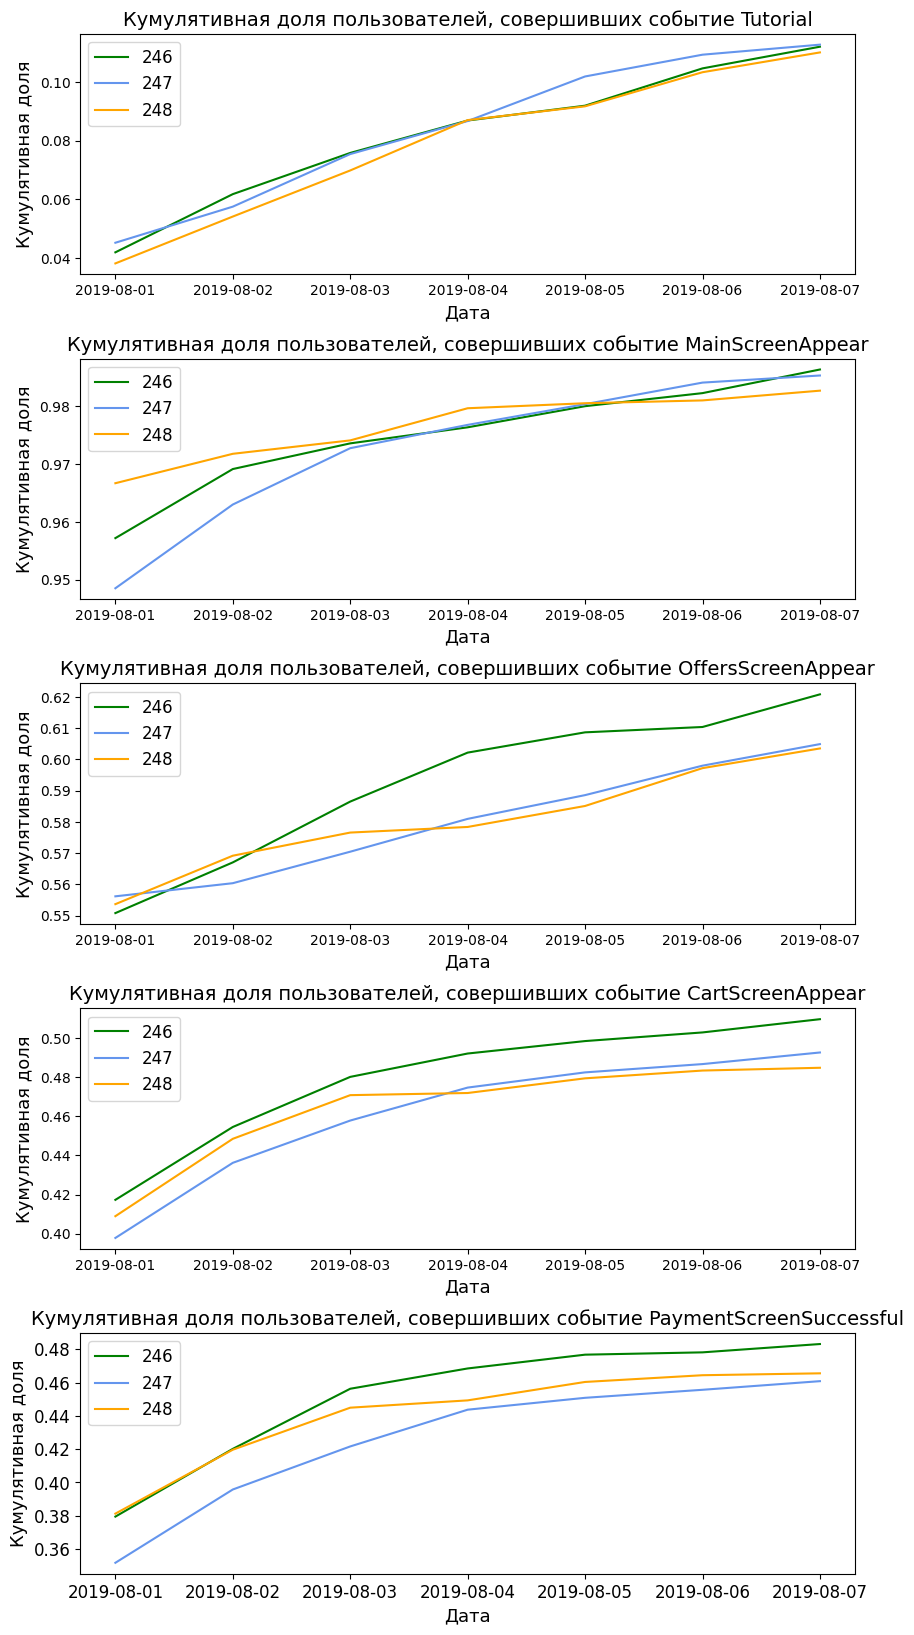

In [83]:
fig, axes = plt.subplots(5, 1)
fig.set_size_inches(10, 20)
plt.subplots_adjust(wspace=0, hspace=0.35)

# Строим графики для каждого события в динамике
for i in range(len(data_actual['event_name'].unique())):
    funct(i)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

<div style="border:solid Green 2px; padding: 20px"> 
В результате анализа долей пользователей в динамике, не было замечено, чтобы экспериментальная группа 248 на каких-то этапах заметно обгоняла контрольные группы, скорее где-то даже проигрывала группе 246.<br>
Однако такой анализ подтверждает, что исследование статистической значимости по результам всего времени А/Б теста верно, а также то, что результат однозначен: статически значимого изменения - нет.<br>


## Выводы и рекомендации:

<div style="border:solid Green 2px; padding: 20px"> 
<b>Выводы:</b><br>
1. Проведён обзор и предобработка данных. Удалены явные дубликаты, изменены типы данных и добавлены новые столбцы для исследователького анализа.<br>
2. Исследовательских анализ данных показал, что туториал проходит всего 11% пользователей. Он является необязательным событием и был исключен из воронки событий<br>
3. Для остальных 4-ёх событий была составлена воронка событий, которая показала, что ~40% пользователей уходят после первого шага "Появление главного экрана". Далее доля перехода высокая: >80%, а на последнем шаге >90%<br>
4. Около 50% пользователей доходят до "Экрана успешной оплаты"<br>
5. Подготовленные для А/В теста группы полные, приблизительно равны по количеству уникальных пользователей и пригодны для А/В тестирования<br>
6. Между группами не была найдено статистически значимой разницы в долях пользователей ни по одному событию, ни за весь период, ни в динамике по дням. Это означает, что нововведние со шрифтами не даст положительного эффекта при полномастштабном внедрении. Необходимо проверять другие гипотезы для повышения доли пользователей с успешной оплатой.<br>
    
<b>Рекомендации: </b>
 1. При следующих А/В тестах формировать группы тем же способом для получения таких же корректных результатов А/В теста.
 2. Необходимо работать в большей степени с переходом пользователей с "главного экрана" на "экран с предложениями". Там наблюдается наибольший отток (~40%).<br>
    Возможные действия:
    - привлекать больше целевых пользователей, которые после просмотра главного экрана будут совершать дальнейшие действия;
    - разработать изменения главного экрана (визуальные или технические), подталкивающие пользователей к дальнейшему переходу;
    - проверить на наличие технических сложностей или ошибок отображения у пользователей на разных типах устройств или с разных регионов.
 3. Проработать качество туториала или добавить подсказки, может быть не все пользователи разбираются в функционале приложения. Из-за этого большая часть уходит.